# Import packages

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Datasets

In [163]:
log_files_path_data = 'Data/'
df_pred = pd.read_csv(log_files_path_data + "LSTModel_outputY3-layer18-14-10.csv",index_col=0)
df_actual = pd.read_csv(log_files_path_data + "actual.csv", index_col = 0)

In [178]:
df_total = pd.concat([df_actual+10, df_pred+10], axis = 1) #zero-value gives problems, hence we add a small quantity. 
#Should still be adjusted to actual price of the stock index
df_total.shape
df_total.columns = ['actual', 'predicted']
df_total = df_total.as_matrix()
df_total.shape[0]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


2059

# Simple additive strategy, no bounds

In this strategy, we assume that we invest $100 each day, buying S&P-500 if our prediction is that the stock goes up and selling otherwise. It is easy to adjust for fixed-percentage transaction costs in our model. We assume in this additive strategy that we incur the transaction cost only if we adjust our position from "long" to "short" and vice versa (otherwise, we do not adjust our position).

In [179]:
def add_strat(df_total, transaction_cost, investment, lower_bound_invest_long, upper_bound_invest_short,
              lower_bound_hold_long, upper_bound_hold_short, daily_interest_rate):
    wealth = [0]*df_total.shape[0]
    profit = 0 #Starting wealth
    recent_profit = 0 #Profit from the previous day
    current_position = 0 #0 = no position, 1 = long, -1 = short
    for i in range(df_total.shape[0]-1):
        if((df_total[i+1,1] - df_total[i,1])/df_total[i,1] > lower_bound_invest_long):
            if(current_position == -1):
                profit -= (2*investment*transaction_cost + recent_profit*transaction_cost) #Sell position and short stock
            else:
                profit -= recent_profit*transaction_cost #Make sure our position is equal to the investment
            recent_profit = investment*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were long
            profit += recent_profit
            current_position = 1
        elif(-(df_total[i+1,1] - df_total[i,1]) / df_total[i,1] < upper_bound_invest_short):
            if(current_position == 1):
                profit -= (2*investment*transaction_cost + recent_profit*transaction_cost) #Sell position and short stock
            else:
                profit -= recent_profit*transaction_cost #Make sure our position is equal to the investment
            recent_profit = -investment*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were short
            profit += recent_profit
            current_position = -1
        elif(lower_bound_invest_long > (df_total[i+1,1] - df_total[i,1])/df_total[i,1] > lower_bound_hold_long):
            profit -= recent_profit*transaction_cost #Make sure our long position equals investment
            recent_profit = investment*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were long
            profit += recent_profit
        elif(upper_bound_invest_short < (df_total[i+1,1] - df_total[i,1])/df_total[i,1] < upper_bound_hold_short):
            profit -= recent_profit*transaction_cost #Make sure our short position equals investment
            recent_profit = -investment*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were short
            profit += recent_profit
        else: #We unwind our position and do not invest
            profit -= (investment + recent_profit)*transaction_cost
            profit += investment * daily_interest_rate #We didn't invest, so we get the interest rate of our bank account.
            
        wealth[i+1] = profit
    return wealth, profit

In [180]:
transaction_cost = 0 #Cost (in percentage of the investment) if we change from long to short and vice versa
investment = 100
lower_bound_invest_long = 0 #Minimum predicted return before we actually buy
upper_bound_invest_short = 0 #Minimum predicted return before we actually short (negative value)
lower_bound_hold_long = 0 #Minimum predicted return to still hold our long position
upper_bound_hold_short = 0 #Minimum predicted return to still hold our short position (negative)
daily_interest_rate = 0.03/365 #interest rate on money that is not invested


add_wealth, add_profit = add_strat(df_total, transaction_cost, investment, lower_bound_invest_long, upper_bound_invest_short,
                       lower_bound_hold_long, upper_bound_hold_short, daily_interest_rate)
print("Total profit: ", add_profit)

Total profit:  8.929641613517088


# Simple multiplicative strategy

In this strategy, we assume that we invest all our money each day, buying S&P-500 if our prediction is that the stock goes up and selling otherwise. It is easy to adjust for fixed-percentage transaction costs in our model. We assume in this multiplicative strategy that we incur the transaction cost only if we adjust our position from "long" to "short" and vice versa (otherwise, we do not adjust our position).

In [181]:
def mult_strat(df_total, transaction_cost, initial_account, lower_bound_invest_long, upper_bound_invest_short,
              lower_bound_hold_long, upper_bound_hold_short, daily_interest_rate):
    wealth = [0]*df_total.shape[0]
    wealth[0] = initial_account
    account = initial_account
    recent_profit = 0 #Profit from the previous day
    current_position = 0 #0 = no position, 1 = long, -1 = short
    for i in range(df_total.shape[0]-1):
        if((df_total[i+1,1] - df_total[i,1])/df_total[i,1] > lower_bound_invest_long):
            account += recent_profit
            if(account < 0):
                print("We are broke at day ", i)
                break
            if(current_position == -1):
                account -= (2*account*transaction_cost - recent_profit*transaction_cost) #Sell position and short stock
                #Recent profit was not yet invested
            elif(recent_profit > 0):
                account -= recent_profit*transaction_cost
            elif(current_position == 0):
                account -= account*transaction_cost
            recent_profit = account*((df_total[i+1,0] - df_total[i,0])/df_total[i,0]) #We were long
            current_position = 1
        elif((df_total[i+1,1] - df_total[i,1]) / df_total[i,1] < upper_bound_invest_short):
            account += recent_profit
            if(account < 0):
                print("We are broke at day ", i) 
                break
            if(current_position == 1):
                account -= (2*account*transaction_cost - recent_profit*transaction_cost) #Sell position and short stock
                #recent_profit is not yet invested
            elif(recent_profit > 0):
                account -= recent_profit*transaction_cost
            elif(current_position == 0):
                account -= account*transaction_cost
            recent_profit = -account*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were short
            current_position = -1
        elif(lower_bound_invest_long > (df_total[i+1,1] - df_total[i,1])/df_total[i,1] > lower_bound_hold_long):
            #We don't change our long position
            if(current_position == 0):
                account *= (1+daily_interest_rate)
            else:
                recent_profit *= (1 + daily_interest_rate)
                recent_profit += account*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were long
            #Account will get updated once we invest, to avoid that our "extra" money generates a return
        elif(upper_bound_invest_short < (df_total[i+1,1] - df_total[i,1])/df_total[i,1] < upper_bound_hold_short):
            #We don't change our long position
            if(current_position == 0):
                account *= (1+daily_interest_rate)
            else:
                recent_profit *= (1 + daily_interest_rate)
                recent_profit += -account*(df_total[i+1,0] - df_total[i,0])/df_total[i,0] #We were short
            #Account will get updated once we invest, to avoid that our "extra" money generates a return
        else: #We unwind our position and do not invest
            account -= account*transaction_cost
            account += recent_profit
            account *= (1+daily_interest_rate) #We didn't invest, so we get the interest rate of our bank account. 
            recent_profit = 0
            current_position = 0
        wealth[i+1] = account + recent_profit
    return_value = (account - initial_account)/initial_account #The total return we generated
    
    return wealth, account, return_value

In [182]:
transaction_cost = 0 #Cost (in percentage of the investment) if we change from long to short and vice versa
initial_account = 100 #Starting wealth
lower_bound_invest_long = 0 #Minimum predicted return before we actually buy
upper_bound_invest_short = -0 #Minimum predicted return before we actually short (negative value)
lower_bound_hold_long = 0 #Minimum predicted return to still hold our long position
upper_bound_hold_short = -0 #Minimum predicted return to still hold our short position (negative)
daily_interest_rate = 0.03/365 #interest rate on money that is not invested

mult_wealth, mult_account, mult_return = mult_strat(df_total, transaction_cost, initial_account, lower_bound_invest_long, upper_bound_invest_short,
              lower_bound_hold_long, upper_bound_hold_short, daily_interest_rate)
print("Final value of our account: ", mult_account)
print("Total return generated: ", mult_return)

Final value of our account:  97.01484161847544
Total return generated:  -0.029851583815245563


To do:
- Find the appropriate values for the risk-free interest rate
- Optimize the bounds using some numerical optimization routine
- Plot wealth process properly
- De-normalize the stock index prices
- Find other possible investment schemes?

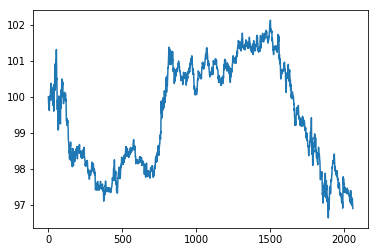

In [185]:
plt.plot(mult_wealth)

In [186]:
plt.plot(add_wealth)